# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [86]:
%matplotlib inline

# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the RNG seed
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [87]:
# Load digit data

mnist = fetch_mldata('MNIST original', data_home='/datasets/mnist')

In [88]:
X, Y = mnist.data, mnist.target

# rescale grayscale values to [0,1]
X = X / 255.0

# re-shuffle the data
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape: ', Y.shape)

data shape:  (70000, 784)
label shape:  (70000,)


In [89]:
# set variables to hold test, dev and train data

test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

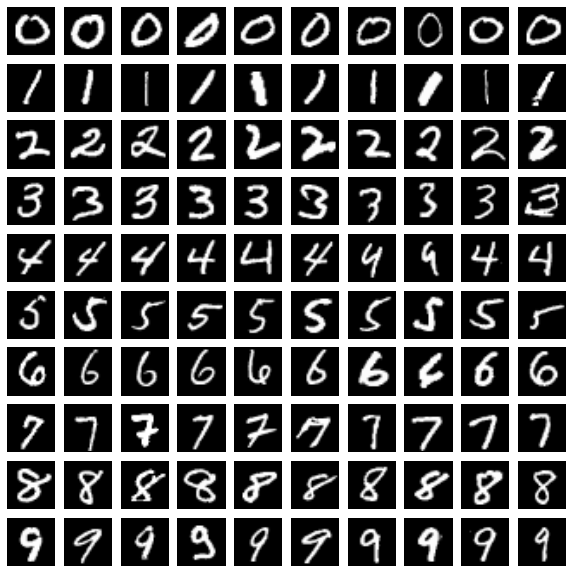

In [90]:
from collections import defaultdict

def P1(num_examples=10): 
    # create a defaultdict to store cases of Y (digits)
    y_cases = defaultdict(int)
    
    # we have 10 unique digits in Y
    num_digits = len(np.unique(Y))
    
    # initialize a plot area (10 x 10 grid)
    f, axarr = plt.subplots(num_digits, num_examples, figsize=(num_examples, (num_digits + num_examples) / 2))
    
    
    for i in range(0, len(X)):
        if y_cases[Y[i]] < num_examples: # as long as we have fewer examples than needed
            pixels = X[i].reshape(28, 28)
            axarr[int(Y[i]), int(y_cases[Y[i]])].imshow(pixels, cmap='gray')
            y_cases[Y[i]] += 1 # we saw a new example of Y
    plt.setp(axarr, xticks=[], yticks=[])
    plt.show()

P1(num_examples=10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [91]:
def P2(k_values):
    
    ### SUDENT START ###
    # loop over values of i and initialize a new knn with k=i
    # then run the classifier and report results
    for i in k_values:
        knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
        knn.fit(mini_train_data, mini_train_labels)
        print("Classification report for classifier %s:\n %s\n Classification score for k = %s: %s\n" 
              % (knn, classification_report(dev_labels, knn.predict(dev_data)), i, knn.score(dev_data, dev_labels)))
    ### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform'):
              precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

 Classification score for k = 1: 0.888

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
       

ANSWER:

The digit '9' appears to be the hardest one for the values of k tested. Except for k=3, the digit '3' was the hardest to predict.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [92]:
def P3(train_sizes, accuracies=[]):
    
    pred_times = {}
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    for t in train_sizes:
        t_data, t_labels = train_data[:t], train_labels[:t]
        knn.fit(t_data, t_labels)
        accuracies.append(knn.score(dev_data, dev_labels))
        
        s = time.time()
        knn.predict(dev_data)
        pred_times[t] = time.time() - s
    return accuracies, pred_times

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
(accuracies, ex_times) = P3(train_sizes, accuracies)
ex_times = dict(ex_times)
for i in range(len(train_sizes)):
    print("Training size: %s Accuracy: %s Time taken: %s" % (train_sizes[i], accuracies[i], ex_times[train_sizes[i]]))

Training size: 100 Accuracy: 0.72 Time taken: 0.10886406898498535
Training size: 200 Accuracy: 0.786 Time taken: 0.1054220199584961
Training size: 400 Accuracy: 0.841 Time taken: 0.21107101440429688
Training size: 800 Accuracy: 0.884 Time taken: 0.21645593643188477
Training size: 1600 Accuracy: 0.902 Time taken: 0.33838915824890137
Training size: 3200 Accuracy: 0.926 Time taken: 0.7517590522766113
Training size: 6400 Accuracy: 0.937 Time taken: 1.5777390003204346
Training size: 12800 Accuracy: 0.959 Time taken: 3.3875319957733154
Training size: 25000 Accuracy: 0.97 Time taken: 7.552667140960693


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [93]:
# fit a regression model to accuracy data
def P4():
    lr = LinearRegression()
    lr.fit(np.array(train_sizes).reshape(-1, 1), np.array(accuracies).reshape(-1, 1))
    p = lr.predict(60000)
    # scale the value of t to range 0 to 1
    t = lambda x: (np.tanh(x) + 1) / 2 # tanh has range of -1 to 1
    return p, t(p)

(p, tp) = P4()
print("Raw accuracy: %s Transformed accuracy (tanh): %s" % (p, tp))

Raw accuracy: [[ 1.24307226]] Transformed accuracy (tanh): [[ 0.92316477]]


ANSWER:

We get an accuracy of 124.3% for n=60000. This is because the prediction is unbounded in linear regression due to the continuous nature of the outcome.

We need to bound the outcome to a more realistic range i.e. 0 to 1 in this case. We will use the tanh function here which is bounded between -1 to 1. We limited that to 0 to 1 in the code above.

Transformation results in an accuracy of 92.3%.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [94]:
# Fit 1-NN and output a confusion matrix

def P5():
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn.fit(train_data, train_labels)
    preds = knn.predict(dev_data)
    return confusion_matrix(dev_labels, preds, labels=range(10)), preds
(cm, preds) = P5()
# print out the confusion matrix
cm

array([[ 99,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 105,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  98,   2,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,  83,   0,   1,   0,   0,   1,   1],
       [  0,   0,   0,   0, 102,   0,   0,   0,   0,   2],
       [  1,   0,   0,   0,   0,  88,   0,   0,   1,   1],
       [  1,   0,   0,   0,   1,   0,  96,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0, 111,   0,   1],
       [  1,   0,   1,   2,   0,   2,   1,   0,  89,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 106]])

We need to find the digits that are confused most frequently and print a few examples of those digits. So first let's find the most frequently confused digits and then make a few plots.

         2
0   1     
2.0 0.0  1
    3.0  2
    7.0  1
3.0 5.0  1
    8.0  1
    9.0  1
4.0 9.0  2
5.0 0.0  1
    8.0  1
    9.0  1
6.0 0.0  1
    4.0  1
7.0 2.0  1
    9.0  1
8.0 0.0  1
    2.0  1
    3.0  2
    5.0  2
    6.0  1


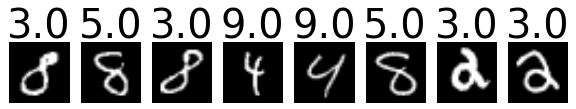

In [95]:
import pandas as pd
def plot_mismatch():
    
    mismatch = []
    for i in range(0, len(preds)):
        if dev_labels[i] != preds[i]:
            mismatch.append([dev_labels[i], preds[i], i])
    
    df = pd.DataFrame(mismatch)
    
    # print out a group of digits and counts of mistaken classes
    print(df.groupby([0, 1]).count())
    
    pixels = [[], []]
    
    # iterate through the most common digits that are mistaken
    for i in mismatch:
        if (i[0] == 2 and i[1] == 3) \
                or (i[0] == 4 and i[1] == 9) \
                or (i[0] == 8 and (i[1] == 5 or i[1] == 3)):
            pixels[0].append(dev_data[i[2]])
            pixels[1].append(i[1])
    
    f, axarr = plt.subplots(1, len(pixels[0]), figsize=(10,10))
    for i in range(0, len(pixels[0])):
        axarr[i].imshow(pixels[0][i].reshape(28, 28), cmap='gray') 
        axarr[i].set_title(pixels[1][i], fontsize=40)
    plt.setp(axarr, xticks=[], yticks=[])
    plt.show()
    
plot_mismatch()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [96]:
# DIY Gaussian Blur

def P6_simple():
    # blur the mini training data
    train_blur_diy = np.copy(mini_train_data)
    train_blur_diy = blur_array(train_blur_diy)
    print('Finished blurring mini train data...')
    
    # blur the dev data
    dev_blur_diy = np.copy(dev_data)
    dev_blur_diy = blur_array(dev_blur_diy)
    print('Finished blurring dev data...\n')
    
    #pre-process training data only
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn.fit(train_blur_diy, mini_train_labels)
    print("Gaussian blur training data only")
    print("Classification report for %s:\n %s\n Classification score for k = 1: %s\n"  
          % (knn, classification_report(dev_labels, knn.predict(dev_data)), knn.score(dev_data, dev_labels)))
    
    # preprocess both training and dev data
    # avoid re-training the model
    print("Gaussian blur BOTH training and dev data")
    print("Classification report for %s:\n %s\n Classification score for k = 1: %s\n"  
          % (knn, classification_report(dev_labels, knn.predict(dev_blur_diy)), knn.score(dev_blur_diy, dev_labels)))
    
    # preprocess dev data only
    # re-train knn
    knn.fit(mini_train_data, mini_train_labels)
    print("Gaussian blur dev data only")
    print("Classification report for %s:\n %s\n Classification score for k = 1: %s\n"  
          % (knn, classification_report(dev_labels, knn.predict(dev_blur_diy)), knn.score(dev_blur_diy, dev_labels)))
    
    
# Iterate over an array of 2d arrays
# and replace individual pixel values.
# New value is calculated by taking mean
# of (pixel value plus mean of the 3x3 cell)
def blur_array(array):
    array = np.asarray(array)
    for a in array:
        a = a.reshape(28, 28)
        for x in range(27):
            for y in range(27):
                a[x, y] = (a[x, y] + blur_pixel(a, x, y))/2.0
    return array

# I just wrap around the edges to get a 3x3 cell
# with the pixel at its center.
# One could add logic to replace 
# pixels outisde boundary with zeroes instead.
def blur_pixel(array, x, y, n=3):
    array = np.roll(np.roll(array, shift=1-x, axis=0), shift=1-y, axis=1)
    return np.mean(array[:n, :n])


P6_simple()

Finished blurring mini train data...
Finished blurring dev data...

Gaussian blur training data only
Classification report for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform'):
              precision    recall  f1-score   support

        0.0       0.92      0.98      0.95        99
        1.0       0.93      0.99      0.96       105
        2.0       0.99      0.82      0.90       102
        3.0       0.81      0.88      0.84        86
        4.0       0.91      0.81      0.86       104
        5.0       0.91      0.88      0.89        91
        6.0       0.95      0.96      0.95        98
        7.0       0.91      0.94      0.93       113
        8.0       0.94      0.91      0.92        96
        9.0       0.79      0.86      0.82       106

avg / total       0.91      0.90      0.90      1000

 Classification score for k = 1: 0.903

Gaussian blur BOTH training

Here are the results from my DIY Gaussian Blur. For pixels on the edges, the blur implemented above wraps around the edge. I will replace those with a 0 in a future implementation of this.
- Training Only accuracy: 90.3%
- Dev Only accuracy: 87.6%
- Training and Dev Both accuracy 90.0%

The results for blurring training-only and both training and dev data are better than the 88.5% for k=1 on non-blurred data.

Let's try the same process as above with scipy's built in ndimage.gaussian_filter.

In [97]:
from scipy import ndimage
def P6():
    
    train_blur = []
    dev_blur = []
    for t in mini_train_data:
        train_blur.append(ndimage.gaussian_filter(t, sigma=1))
    for d in dev_data:
        dev_blur.append(ndimage.gaussian_filter(d, sigma=1))
    
    #pre-process training data only
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn.fit(train_blur, mini_train_labels)
    print("Gaussian blur training data only")
    print("Classification report for %s:\n %s\n Classification score for k = 1: %s\n"  
          % (knn, classification_report(dev_labels, knn.predict(dev_data)), knn.score(dev_data, dev_labels)))
    
    # preprocess both training and dev data
    # avoid re-training the model
    print("Gaussian blur BOTH training and dev data")
    print("Classification report for %s:\n %s\n Classification score for k = 1: %s\n"  
          % (knn, classification_report(dev_labels, knn.predict(dev_blur)), knn.score(dev_blur, dev_labels)))
    
    # preprocess dev data only
    # re-train knn
    knn.fit(mini_train_data, mini_train_labels)
    print("Gaussian blur dev data only")
    print("Classification report for %s:\n %s\n Classification score for k = 1: %s\n"  
          % (knn, classification_report(dev_labels, knn.predict(dev_blur)), knn.score(dev_blur, dev_labels)))    
P6()

Gaussian blur training data only
Classification report for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform'):
              precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.94      0.99      0.96       105
        2.0       0.96      0.79      0.87       102
        3.0       0.80      0.79      0.80        86
        4.0       0.92      0.88      0.90       104
        5.0       0.91      0.81      0.86        91
        6.0       0.94      0.96      0.95        98
        7.0       0.90      0.95      0.92       113
        8.0       0.88      0.95      0.91        96
        9.0       0.82      0.86      0.84       106

avg / total       0.90      0.90      0.90      1000

 Classification score for k = 1: 0.898

Gaussian blur BOTH training and dev data
Classification report for KNeighborsClassifier(algorit

ANSWER:

I used the ndimage.gaussian_filter provided by the library. I got the following results from applying the gaussian blur: 
- Training Only accuracy: 89.8%
- Dev Only accuracy: 88.5%
- Training and Dev Both accuracy 89.5%

The results for blurring training-only and both training and dev data are better than the 88.5% for k=1 on non-blurred data.

Note: the percentages above might change when the notebook is re-run because we shuffle X and Y. Please refer to the function output for the actual accuracies.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [98]:
#def P7(): 

# convert values to 0 or 1
# using mean of the array as default threshold
def binarize(pixels = [], threshold=None):
    if threshold is None:
        threshold = np.mean(pixels)
    for i in range(len(pixels)):
        pixels[i] = (1 if pixels[i] > threshold else 0)
    return pixels

# convert values to 0, 1 or 2
# using a lower and an upper threhold
# default thresholds are the lower and upper quartile values
def ternarize(pixels = [], thresholds=(None, None)):
    upper, lower = thresholds
    if lower is None:
        lower = np.percentile(pixels, 25, 0)
    if upper is None:
        upper = np.percentile(pixels, 75, 0)
    
    for i in range(len(pixels)):
        if pixels[i] < lower:
            pixels[i] = 0
        elif pixels[i] > upper:
            pixels[i] = 2
        else:
            pixels[i] = 1
    return pixels

def P7():
    # BernoulliNB with binarize
    train_data_bin = np.copy(mini_train_data)
    for i in train_data_bin:
        i = binarize(i)

    bnb = BernoulliNB(fit_prior=False)
    bnb.fit(train_data_bin, mini_train_labels)

    dev_data_bin = np.copy(dev_data)
    for i in dev_data_bin:
        i = binarize(i)

    print("Classifier: %s Accuracy score with binarization:%s \n" % (bnb, bnb.score(dev_data_bin, dev_labels)))
    
    # BernoulliNB with ternarize
    train_data_ter = np.copy(mini_train_data)
    for i in train_data_ter:
        i = ternarize(i)
    dev_data_ter = np.copy(dev_data)
    for i in dev_data_ter:
        i = ternarize(i)

    mnb = MultinomialNB(fit_prior=False)
    mnb.fit(train_data_ter, mini_train_labels)

    print("Classifier: %s Accuracy score with ternarization:%s \n" % (mnb, mnb.score(dev_data_ter, dev_labels)))

P7()    

Classifier: BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False) Accuracy score with binarization:0.816 

Classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False) Accuracy score with ternarization:0.805 



ANSWER:

The multinomial version (accuracy: 80.5%) does not improve the results versus the bernoulli version (accuracy: 81.6%) because, I suppose, we are adding noise by re-coding pixels as gray.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?
Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [99]:
# GridSearchCV
def P8(alphas=[]):
    bnb = BernoulliNB(binarize=0.5, fit_prior=False)
    gsc = GridSearchCV(bnb, alphas)
    gsc.fit(mini_train_data, mini_train_labels)
    return gsc

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

for i in nb.grid_scores_:
    print(i)

print("Best alpha: %s Best score: %s" % (nb.best_params_, nb.best_score_))

mean: 0.09200, std: 0.00080, params: {'alpha': 0.0}
mean: 0.81700, std: 0.02076, params: {'alpha': 0.0001}
mean: 0.82000, std: 0.01868, params: {'alpha': 0.001}
mean: 0.82100, std: 0.01811, params: {'alpha': 0.01}
mean: 0.81700, std: 0.01868, params: {'alpha': 0.1}
mean: 0.80000, std: 0.01188, params: {'alpha': 0.5}
mean: 0.79400, std: 0.01246, params: {'alpha': 1.0}
mean: 0.78400, std: 0.01934, params: {'alpha': 2.0}
mean: 0.72000, std: 0.02495, params: {'alpha': 10.0}
Best alpha: {'alpha': 0.01} Best score: 0.821


ANSWER:

The best value for alpha is 0.01 which results in an accuracy of 82%.
The accuracy is 9.2% when alpha is 0.

I'm not sure how a value of 0.01 is related to Lidstone smoothing but, per the scikit-learn docs, that's what is happening here. "Lidstone" smoothing applied at an alpha value of 0.01 gives the best result in this case. According to the docs, the smoothing prevents 0 probabilities from being used in comparisons.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [100]:
# GaussianNB
def P9():
    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    print("Gaussian without mods: %s" % gnb.score(dev_data, dev_labels))
    
    gnb_theta = gnb.theta_.copy()
    gnb_sigma = gnb.sigma_.copy()
    
    # change theta_ and sigma_
    # manually try a few different values and pick the ~best
    for i in range(len(gnb.theta_)):
        gnb.theta_[i] -= 0.1
    for i in range(len(gnb.sigma_)):
        gnb.sigma_[i] += 0.05
    
    print("Gaussian with modified theta and sigma: %s" % gnb.score(dev_data, dev_labels))

P9()

Gaussian without mods: 0.621
Gaussian with modified theta and sigma: 0.806


ANSWER:
GaussianNB yields a low accuracy of 62.1% without modifying theta_ and signma_. theta_ is the mean of each feature per class and sigma_ is the variance of each feature per class.

I tried various values for theta_ and sigma_ but what worked best is hard coded  above. Reducing the mean of each feature per class by 0.1 and increasing the variance by 0.05 resulted in an accuracy of 80.6%.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

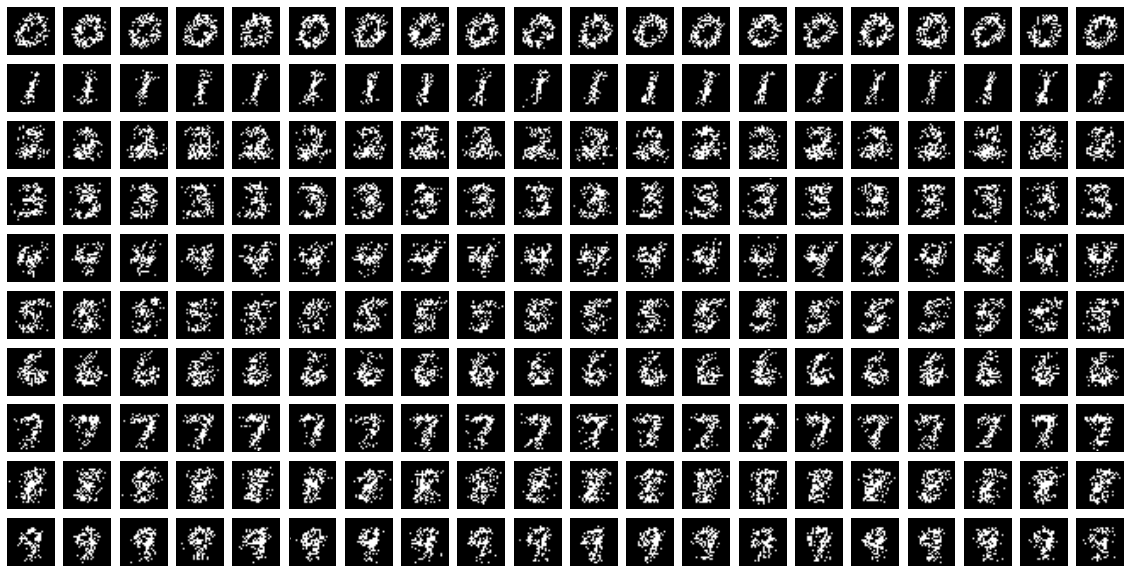

In [101]:
# Generate numbers via BernoulliNB 
def P10(num_examples):
    
    bnb = BernoulliNB(binarize=0.5, alpha=0.01, fit_prior=False)
    bnb.fit(mini_train_data, mini_train_labels)
    
    numbers = 10
    f, axarr = plt.subplots(numbers, num_examples, figsize=(20, 10))
    for i in range(numbers):
        for j in range(num_examples):
            num_prob = np.exp(bnb.feature_log_prob_[i])
            # create an array with 0's and 1's based on 
            # comparison with randomly generted values
            num = np.random.rand(784) < num_prob
            axarr[i, j].imshow(num.reshape(28, 28), cmap='gray')
    plt.setp(axarr, xticks=[], yticks=[])
    plt.show()

P10(20)

ANSWER:

The generated digits look fuzzy and some barely look like the numbers they represent. However, examples of each digit appear to be more homogeneous when compared to examples of hand-written digits.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [102]:
def P11(buckets, correct, total):
    bnb = BernoulliNB(alpha=0.01, binarize=0.5, fit_prior=False)
    bnb.fit( mini_train_data , mini_train_labels)
    
    # predict_proba returs the probability 
    # that each data point in mini_train_data has 
    # for being in 1..10. That is each point in predict_proba
    # is an array of length 10
    predicted = bnb.predict_proba(dev_data)
    for i in range(len(predicted)):
        for j in range(len(buckets)):
            # increment bucket count whenever probability 
            # is greater than bucket value
            if np.max(predicted[i]) >= buckets[j]:
                total[j] += 1
            # np.argmax gives the index of max value
            # which in this case happens to be the class.
            # increment the correct counter if predict_proba
            # had the max probability for the correct class
            if np.argmax(predicted[i]) == dev_labels[i]:
                correct[j] += 1

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
   accuracy = 0.0
   if (total[i] > 0): accuracy = correct[i] / total[i]
   print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total = 1000    accuracy = 0.818
p(pred) <= 0.9000000000000    total = 970    accuracy = 0.843
p(pred) <= 0.9990000000000    total = 884    accuracy = 0.925
p(pred) <= 0.9999900000000    total = 798    accuracy = 1.025
p(pred) <= 0.9999999000000    total = 743    accuracy = 1.101
p(pred) <= 0.9999999990000    total = 682    accuracy = 1.199
p(pred) <= 0.9999999999900    total = 607    accuracy = 1.348
p(pred) <= 0.9999999999999    total = 529    accuracy = 1.546
p(pred) <= 1.0000000000000    total = 499    accuracy = 1.639


ANSWER:

The results above indicate that the classifier is weakly calibrated. The accuracy increases linearly with posterior probability (thus eliminating poorly calibrated). However, the accuracy (~84.3%) is not nearly 90% when the posterior probability is 0.9. Therefore, weakly calibrated appears to be the best choice here.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [103]:
# Do extra credit work here
def P_Extra():

    mt_sums = []
    mini_train_copy = np.copy(mini_train_data)
    for i in mini_train_copy:
        i = i.reshape(28, 28)
        # sum up rows and columns and stick 'em together
        mt_sums.append(np.concatenate((np.sum(i, axis=1), np.sum(i, axis=0)), axis=0))
    
    dev_sums = []
    dev_data_copy = np.copy(dev_data)
    for i in dev_data_copy:
        i = i.reshape(28, 28)
        dev_sums.append(np.concatenate((np.sum(i, axis=1), np.sum(i, axis=0)), axis=0))
    
    binarize_threshold = 0.15
    
    bnb = BernoulliNB(binarize=binarize_threshold, fit_prior=False)
    bnb.fit(mini_train_copy, mini_train_labels)
    print("Classifier: %s Accuracy score with binarization:%s \n" % (bnb, bnb.score(dev_data_copy, dev_labels)))
    
    alphas = {'alpha': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}
    nb = bnb_best_params(alphas)

    for i in nb.grid_scores_:
        print(i)

    print("Best alpha: %s Best score: %s" % (nb.best_params_, nb.best_score_))

def bnb_best_params(alphas=[]):
    bnb = BernoulliNB(binarize=0.15, fit_prior=False)
    gsc = GridSearchCV(bnb, alphas)
    gsc.fit(mini_train_copy, mini_train_labels)
    return gsc    
    
P_Extra()

Classifier: BernoulliNB(alpha=1.0, binarize=0.15, class_prior=None, fit_prior=False) Accuracy score with binarization:0.815 

mean: 0.09200, std: 0.00080, params: {'alpha': 0.0}
mean: 0.82000, std: 0.01969, params: {'alpha': 0.05}
mean: 0.81900, std: 0.02001, params: {'alpha': 0.1}
mean: 0.81900, std: 0.02001, params: {'alpha': 0.15}
mean: 0.81900, std: 0.01837, params: {'alpha': 0.2}
mean: 0.82000, std: 0.01819, params: {'alpha': 0.25}
mean: 0.82000, std: 0.01819, params: {'alpha': 0.3}
mean: 0.82100, std: 0.01945, params: {'alpha': 0.35}
mean: 0.82100, std: 0.01945, params: {'alpha': 0.4}
mean: 0.82100, std: 0.01813, params: {'alpha': 0.45}
mean: 0.81800, std: 0.01705, params: {'alpha': 0.5}
Best alpha: {'alpha': 0.35} Best score: 0.821


ANSWER:

Using GridSearchCV over alphas, we get 82.1% as the best prediction rate. 